In [1]:
import os
import csv
import matplotlib

import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt

from pygrid import *
from igraph import *

In [2]:
font = {'weight':'normal','size':16}
matplotlib.rc('font', **font)

## Create 9-bus test system network

In [3]:
graph9bus=Graph() 
    
with open('../9-bus/9busnode.csv','r') as fnode:
    node=csv.reader(fnode)
    mynode=list(node)
    for row in mynode:
        graph9bus.add_vertex(name=row[0])
        
node_num=graph9bus.vcount()
print(node_num)

Y=np.zeros((node_num,node_num))
with open('../9-bus/9busbranch.csv','r') as fbranch:
    branch=csv.reader(fbranch)
    mybranch=list(branch)
    for row in mybranch:
        B=(1/complex(float(row[2]),float(row[3]))).imag
        graph9bus.add_edge(row[0],row[1])
        Y[int(row[0])-1,int(row[1])-1]=-B
        Y[int(row[1])-1,int(row[0])-1]=-B
        
P_list=list()
Q_list=list()
with open('../9-bus/9busP.csv','r') as csvfileP:
    csvreaderP=csv.reader(csvfileP)
    mycsvP=list(csvreaderP)
    for row in mycsvP:
        P_list.append(row[1])
        Q_list.append(row[2])
        
graph9bus.vs['name'] = range(1,node_num+1)
graph9bus.vs['name'] = range(1,node_num+1)
graph9bus.vs['P_injection'] = P_list[:node_num]
graph9bus.vs['Q_injection'] = Q_list[:node_num]

params = pd.read_csv('../9-bus/9busY.csv')
graph9bus.vs['weight'] = params['weight']

9


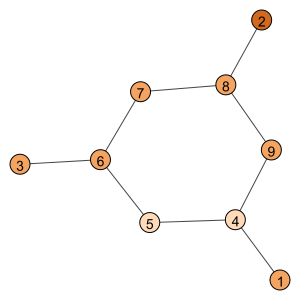

In [4]:
## graph9bus.plot()
layout = graph9bus.layout("kk")
visual_style = {}
visual_style["vertex_size"] = 20
color_dict = {1.0: "sandybrown", 0.5: "peachpuff", 1.8: "chocolate"}
visual_style["vertex_color"] = [color_dict[weight] for weight in graph9bus.vs["weight"]]
visual_style["vertex_label"] = graph9bus.vs["name"]
visual_style["layout"] = layout
visual_style["bbox"] = (300, 300)
visual_style["margin"] = 20
plot(graph9bus, '9.png', **visual_style)

In [5]:
df9bus = pd.DataFrame([graph9bus.vcount(),
                       graph9bus.ecount(),
                       graph9bus.is_weighted(),
                       graph9bus.is_directed(),
                       graph9bus.is_connected(),
                       graph9bus.maxdegree(),
                       graph9bus.average_path_length(directed=False, unconn=False),
                       graph9bus.diameter(directed=False, unconn=False, weights=None)],
                      columns = ['value'],
                      index = ['number of nodes',
                               'number of edges',
                               'weighted or not',
                               'directed or not',
                               'connected or not',
                               'maximum degree',
                               'average path length',
                               'diameter'])
display(df9bus)

,value
number of nodes,9
number of edges,9
weighted or not,False
directed or not,False
connected or not,True
maximum degree,3
average path length,2.33333
diameter,4


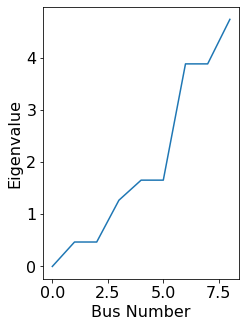

In [6]:
laplacian = graph9bus.laplacian()
[w,v] = np.linalg.eig(laplacian)
sorted_w = sorted(w)

plt.figure(figsize  = (3.5,5))
plt.plot(sorted_w)
plt.xlabel('Bus Number', fontsize = 16)
plt.ylabel('Eigenvalue', fontsize = 16)
plt.savefig('9eigen.png', bbox_inches = 'tight')

## Create 123-node test feeder network

In [7]:
gl = gridlabObject(filename="123IEEE_python.glm", 
                   workingDirectory='..\\123-bus\\', 
                   header_file=os.path.join("IEEE_123_TestFeeder", "123nodeglmheader.txt"))
hardFiles = ['123nodeglmconductors.txt', 
             '123nodeglmlinespacing.txt', 
             '123nodeglmlineconfig.txt', 
             '123nodeglmlines.txt', 
             '123nodeglmloads.txt', 
             '123nodeglmnodes.txt', 
             '123nodeglmtransformer.txt', 
             '123nodeglmcapacitors.txt', 
             '123nodeglmregulators.txt']
for filename in hardFiles:
    filename = os.path.join("IEEE_123_TestFeeder", filename)
    newObjs = gl.read_glm_file(filename)
    for objType in newObjs.keys():
        if objType not in gl.objects.keys():
            gl.objects[objType] = {}
        for obj in newObjs[objType].keys():
            gl.objects[objType][obj] = newObjs[objType][obj]
for typeObj in gl.objects.keys():
    allobjects = sorted(gl.objects[typeObj].keys())
    for obj in gl.objects[typeObj].keys():
        if obj == "node350":
            pass #we're skipping this node for some reason
        if obj == "node610":
            gl.objects[typeObj][obj]["nominal_voltage"] = "277.1"
        outline = gl.object_string(gl.objects[typeObj][obj], typeObj)
        with open(gl.outFileName, 'a') as outFile:
            outFile.write(outline + "\n")
            
graph123bus = Graph() 
ob = gl.objects
overheadline = ob['overhead_line']
graph123bus.vs['name'] = []
for k,v in overheadline.items():
    linefrom = v['from']
    lineto = v['to']
    vs = graph123bus.vs
    if linefrom not in vs['name']:
        graph123bus.add_vertex(linefrom)
    if lineto not in vs['name']:
        graph123bus.add_vertex(lineto)
    graph123bus.add_edge(linefrom,lineto)
    
undergroundline=ob['underground_line']
for k,v in undergroundline.items():
    linefrom=v['from']
    lineto=v['to']
    vs=graph123bus.vs
    if linefrom not in vs['name']:
        graph123bus.add_vertex(linefrom)
    if lineto not in vs['name']:
        graph123bus.add_vertex(lineto)
    graph123bus.add_edge(linefrom,lineto)

regulators=ob['regulator']
for k,v in regulators.items():
    regulatorfrom=v['from']
    regulatorto=v['to']
    vs=graph123bus.vs
    if regulatorfrom not in vs['name']:
        graph123bus.add_vertex(regulatorfrom)
    if regulatorto not in vs['name']:
        graph123bus.add_vertex(regulatorto)
    graph123bus.add_edge(regulatorfrom,regulatorto)
    
transformer=ob['transformer']
for k,v in transformer.items():
    transformerfrom=v['from']
    transformerto=v['to']
    vs=graph123bus.vs
    if transformerfrom not in vs['name']:
        graph123bus.add_vertex(transformerfrom)
    if transformerto not in vs['name']:
        graph123bus.add_vertex(transformerto)
    graph123bus.add_edge(transformerfrom,transformerto)
    
nodeNumber=graph123bus.vcount()
print(nodeNumber) 

graph123bus.vs['name'] = range(1,nodeNumber+1)
params = pd.read_csv('../123-bus/IEEE_123_TestFeeder/123busY.csv')
graph123bus.vs['weight'] = params['Weight']

125


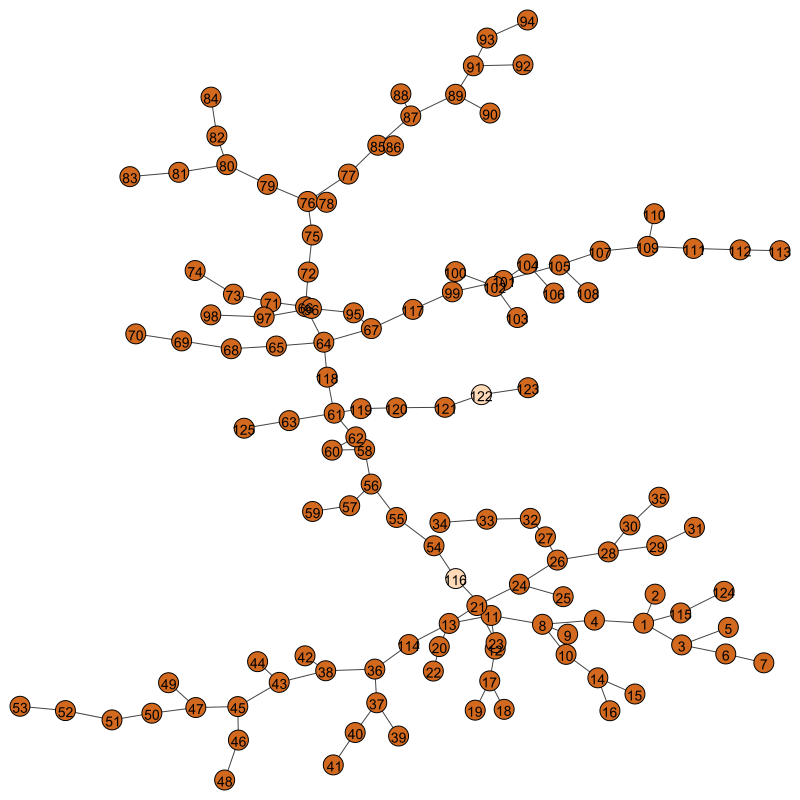

In [8]:
# graph123bus.plot()
layout = graph123bus.layout("kk")
visual_style = {}
visual_style["vertex_size"] = 20
color_dict = {1.0: "chocolate", 0: "peachpuff"}
visual_style["vertex_color"] = [color_dict[weight] for weight in graph123bus.vs["weight"]]
visual_style["vertex_label"] = graph123bus.vs["name"]
visual_style["layout"] = layout
visual_style["bbox"] = (800, 800)
visual_style["margin"] = 20
plot(graph123bus, "123.png", **visual_style)

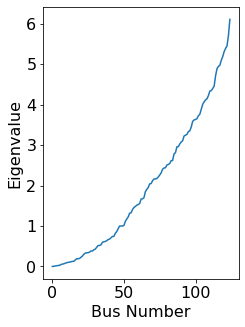

In [9]:
laplacian = graph123bus.laplacian()
[w,v] = np.linalg.eig(laplacian)
sorted_w = sorted(w)

plt.figure(figsize  = (3.5,5))
plt.plot(sorted_w)
plt.xlabel('Bus Number', fontsize = 16)
plt.ylabel('Eigenvalue', fontsize = 16)
# plt.title('123-Bus Eigenvalues')
plt.savefig('123eigen.png', bbox_inches = 'tight')

In [10]:
df123bus = pd.DataFrame([graph123bus.vcount(),
                         graph123bus.ecount(),
                         graph123bus.is_weighted(),
                         graph123bus.is_directed(),
                         graph123bus.is_connected(),
                         graph123bus.maxdegree(),
                         graph123bus.average_path_length(directed=False, unconn=False),
                         graph123bus.diameter(directed=False, unconn=False, weights=None)],
                        columns = ['value'],
                        index = ['number of nodes',
                                 'number of edges',
                                 'weighted or not',
                                 'directed or not',
                                 'connected or not',
                                 'maximum degree',
                                 'average path length',
                                 'diameter'])
display(df123bus)

,value
number of nodes,125
number of edges,124
weighted or not,False
directed or not,False
connected or not,True
maximum degree,4
average path length,12.0988
diameter,30


## Save network

In [11]:
graph9bus.save('IEEE9bus.gml')
graph123bus.save('IEEE123bus.gml')